weight:  [[ 5.0013027  1.1923108 -3.4128077  5.612523 ]]


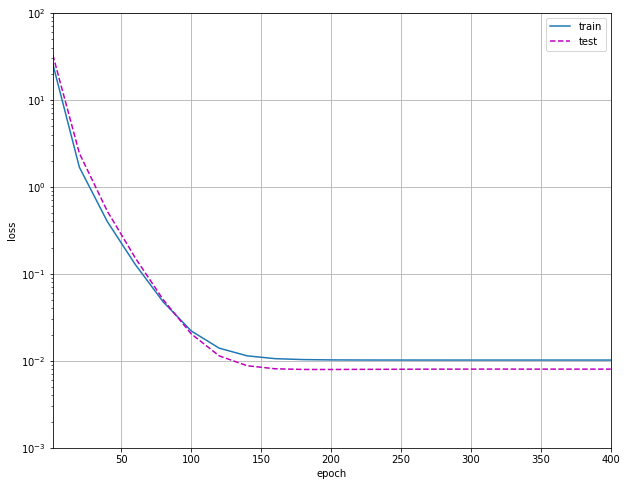

In [1]:
import math
import torch
import sys
sys.path.append("~/MCode/MachineLearning")

import numpy as np
from torch.utils import data
from torch import nn
from utils import Accumulator
from utils.plot import Animator


__doc__ = """多项式：过拟合和欠拟合"""


def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)

    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())

    return metric[0] / metric[1]


def load_array(data_arrays, batch_size, is_train=True):
    """构造一个 PyTorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)

    # y_hat.type(y.dtype): 将 y_hat 转换成 y 的数据类型
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())


def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1, 1)), batch_size)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel="epoch", ylabel="loss", yscale="log",
                        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                        legend=["train", "test"])

    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, trainer)

        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))

    print("weight: ", net[0].weight.data.numpy())


max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
# Under fitting
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight:  [[3.0370946 4.4255934]]


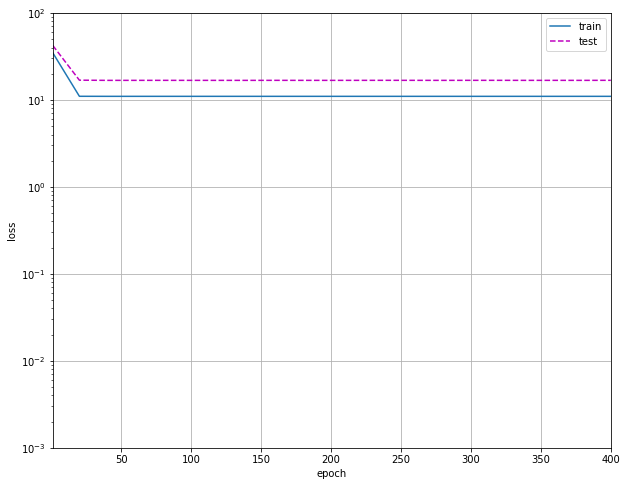

In [2]:
# 只拿前 2 个特征
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight:  [[ 4.95610285e+00  1.30853093e+00 -3.21375084e+00  5.04240942e+00
  -5.31179547e-01  1.50936973e+00 -1.02384001e-01  3.87958705e-01
   4.19674069e-02 -2.02762242e-02  1.32109448e-01 -1.73054248e-01
  -8.72503445e-02  9.32157561e-02 -2.22982034e-01  1.02177896e-01
   5.21837443e-04  1.46576256e-01 -2.90757045e-02 -1.08310021e-01]]


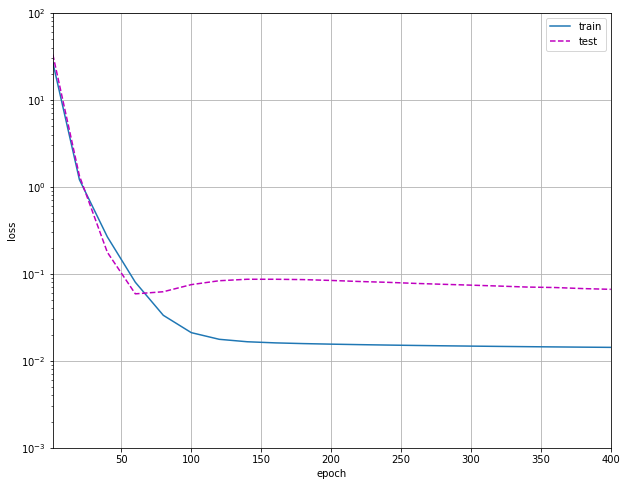

In [3]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])